In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import unicodedata
import re
import os
import io
import time
import matplotlib.ticker as ticker

In [3]:
path_to_zip = tf.keras.utils.get_file('spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip', extract=True)

2646016/2638744 [==============================] - 0s 0us/step


In [0]:
path_to_file = os.path.dirname(path_to_zip) + '/spa-eng/spa.txt'

In [7]:
os.path.dirname(path_to_zip)

'/root/.keras/datasets'

In [5]:
path_to_file

'/root/.keras/datasets/spa-eng/spa.txt'

In [0]:
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
  w = unicode_to_ascii(w.lower().strip())

  w = re.sub(r"([?.!,¿])", r' \1 ', w)
  w = re.sub(r'[" "]+', ' ', w)
  w = re.sub(r"[^a-zA-Z?.!,¿]+", ' ', w)
  w = w.strip()
  w = '<start> ' + w + ' <end>'
  return w

In [9]:
en_sentence = u"May I borrow this book?"
sp_sentence = u"¿Puedo tomar prestado este libro?"
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(sp_sentence).encode('utf-8'))

<start> may i borrow this book ? <end>
b'<start> \xc2\xbf puedo tomar prestado este libro ? <end>'


In [0]:
def create_dataset(path, num_examples):
  with open(path, encoding='utf8') as f:
    lines = f.read().strip().split('\n')
  word_pairs = [[preprocess_sentence(w) for w in l.split('\t')] for l in lines[:num_examples]]

  return zip(*word_pairs)

In [22]:
en, sp = create_dataset(path_to_file, None)
print(en[-1])
print(sp[-1])

<start> if you want to sound like a native speaker , you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo . <end>
<start> si quieres sonar como un hablante nativo , debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un musico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado . <end>


In [0]:
def max_length(tensor):
  return max(len(t) for t in tensor)

In [0]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
  lang_tokenizer.fit_on_texts(lang)
  tensor = lang_tokenizer.texts_to_sequences(lang)
  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
  return tensor, lang_tokenizer

In [0]:
def load_dataset(path, num_examples=None):
  targ_lang, inp_lang = create_dataset(path, num_examples)

  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, target_lang_tokenizer = tokenize(targ_lang)

  return input_tensor, target_tensor, inp_lang_tokenizer, target_lang_tokenizer

In [0]:
# Limit the usage for fast training
num_examples = 30000

input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

max_lang_inp, max_lang_targ = max_length(input_tensor), max_length(target_tensor)

In [40]:
print(max_lang_inp)
print(max_lang_targ)

16
11


In [41]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

24000 24000 6000 6000


In [0]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

In [43]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
9 ----> el
17 ----> se
6240 ----> endeudo
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
14 ----> he
236 ----> ran
417 ----> into
1599 ----> debt
3 ----> .
2 ----> <end>


In [0]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [45]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 16]), TensorShape([64, 11]))

## Modeling Part

In [0]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, units, batch_sz):
    super(Encoder, self).__init__()
    self.vocab_size = vocab_size
    self.embedding_dim = embedding_dim
    self.units = units
    self.batch_sz = batch_sz
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim, mask_zero=True)
    self.gru = tf.keras.layers.GRU(units, return_sequences=True, return_state=True)

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state=hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros(shape=(self.batch_sz, self.units))

In [47]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 16, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [0]:
class Attention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(Attention, self).__init__()
    self.units = units
    self.w1 = tf.keras.layers.Dense(units)
    self.w2 = tf.keras.layers.Dense(units)
    self.v = tf.keras.layers.Dense(1)

  def call(self, query, value):
    query = tf.expand_dims(query, 1) # query == encoder state

    score = self.v(tf.nn.tanh(self.w1(query) + self.w2(value)))

    attention_weight = tf.nn.softmax(score, axis=1)
    context_vector = attention_weight * value
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weight


In [49]:
attention_layer = Attention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 16, 1)


In [0]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, units, batch_sz):
    super(Decoder, self).__init__()
    self.vocab_size = vocab_size
    self.embedding_dim = embedding_dim
    self.units = units
    self.batch_sz = batch_sz
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim, mask_zero=True)
    self.gru = tf.keras.layers.GRU(units, return_sequences=True, return_state=True)
    self.fc =tf.keras.layers.Dense(vocab_size)
    self.attention = Attention(self.units)

  
  def call(self, x, hidden, enc_output):
    context_vector, attention_weight = self.attention(hidden, enc_output)

    x = self.embedding(x)
    x = tf.concat([tf.expand_dims(context_vector, 1),
                   x], axis=-1)
    output, state = self.gru(x)

    output = tf.reshape(output, shape=(-1, output.shape[2]))
    print(output.shape)
    x = self.fc(output)

    return x, state, attention_weight

In [53]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

(64, 1024)
Decoder output shape: (batch_size, vocab size) (64, 4935)


In [0]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [0]:
checkpoint_dir = './training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

checkpoint = tf.train.Checkpoint(optimizer=optimizer, encoder=encoder, decoder=decoder)

In [0]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [57]:
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.7597
Epoch 1 Batch 100 Loss 2.2232
Epoch 1 Batch 200 Loss 1.9256
Epoch 1 Batch 300 Loss 1.5001
Epoch 1 Loss 1.9935
Time taken for 1 epoch 42.40679717063904 sec

Epoch 2 Batch 0 Loss 1.5206
Epoch 2 Batch 100 Loss 1.3643
Epoch 2 Batch 200 Loss 1.2670
Epoch 2 Batch 300 Loss 1.1451
Epoch 2 Loss 1.2869
Time taken for 1 epoch 29.831268072128296 sec

Epoch 3 Batch 0 Loss 0.8917
Epoch 3 Batch 100 Loss 0.9284
Epoch 3 Batch 200 Loss 1.0298
Epoch 3 Batch 300 Loss 0.7754
Epoch 3 Loss 0.8796
Time taken for 1 epoch 29.141713857650757 sec

Epoch 4 Batch 0 Loss 0.6082
Epoch 4 Batch 100 Loss 0.5520
Epoch 4 Batch 200 Loss 0.5140
Epoch 4 Batch 300 Loss 0.6679
Epoch 4 Loss 0.5730
Time taken for 1 epoch 29.117304801940918 sec

Epoch 5 Batch 0 Loss 0.4261
Epoch 5 Batch 100 Loss 0.3908
Epoch 5 Batch 200 Loss 0.3947
Epoch 5 Batch 300 Loss 0.3469
Epoch 5 Loss 0.3700
Time taken for 1 epoch 28.80205774307251 sec

Epoch 6 Batch 0 Loss 0.1554
Epoch 6 Batch 100 Loss 0.2316
Epoch 6 Batch 200 L

In [0]:
def evaluate(sentence):
  attention_plot = np.zeros((max_lang_targ, max_lang_inp))

  sentence = preprocess_sentence(sentence)

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_lang_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_lang_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)
    print('dec input',dec_input)
    print('enc_out', enc_out)
    print('prediction', predictions)
    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += targ_lang.index_word[predicted_id] + ' '

    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [0]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [0]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [71]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

(1, 1024)
dec input tf.Tensor([[1]], shape=(1, 1), dtype=int32)
enc_out tf.Tensor(
[[[ 0.01547313  0.03391477 -0.0561979  ... -0.00334854  0.10497806
   -0.00876865]
  [-0.07509471 -0.04248757 -0.03827157 ... -0.084919    0.28666818
   -0.23666514]
  [ 0.1043661   0.037481    0.48954138 ...  0.09271576 -0.9259604
    0.11577791]
  ...
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]]], shape=(1, 16, 1024), dtype=float32)
prediction tf.Tensor(
[[-10.368306  -11.667063    2.2367306 ... -10.2382145 -10.297544
   -5.6003   ]], shape=(1, 4935), dtype=float32)
(1, 1024)
dec input tf.Tensor([[10]], shape=(1, 1), dtype=int32)
enc_out tf.Tensor(
[[[ 0.01547313  0.03391477 -0.0561979  ... -0.00334854  0.10497806
   -0.00876865]
  [-0.07509471 -0.04248757 -0.03827157 ... -0.084919    0.28666818
   -0.23666514]
  [ 0.1043661

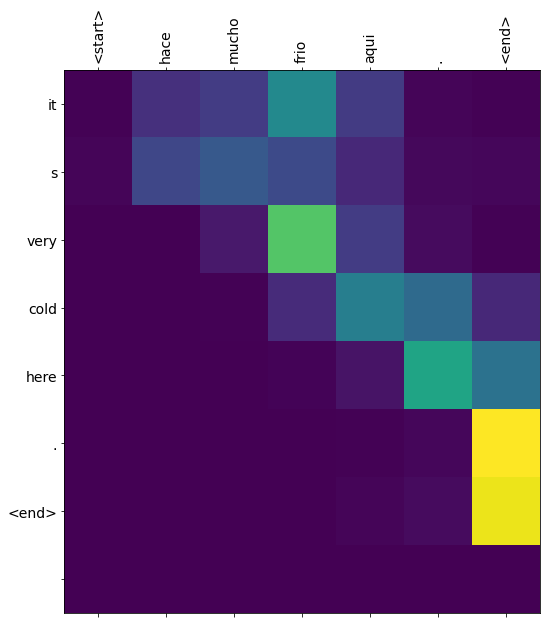

In [83]:
translate(u'hace mucho frio aqui.')